In [1]:
#set adequate flag for Theano on lxplus
import theano
theano.config.gcc.cxxflags = '-march=corei7'

In [2]:
#check config
import keras.backend as K
K.set_image_dim_ordering('th')
#print 'Keras backend:', K.backend()
#print 'Keras image ordering operator: ', K.image_dim_ordering()

Using Theano backend.


In [3]:
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import ROOT
import itertools
import math

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Welcome to JupyROOT 6.07/07


In [36]:
#shifts the subjets towards the 1st PFJet based on the highest pt subjet
#eta'_i = eta_i - eta_0
#phi'_i = phi_i - phi_0
def translate(etas_1, phis_1, etas_2, phis_2, pfjets):
    x1Shift = []
    y1Shift = []
    x2Shift = []
    y2Shift = []
    
    #center based on 1st PFJet
    xCenter = pfjets[0][0]#1st PFJet eta
    yCenter = pfjets[0][1]#1st PFJet phi
    
    #etas and phis from subjets from 1st PFJet
    x1 = etas_1
    y1 = phis_1
    for ix, iy in zip(x1, y1):
        x1Shift.append( ix - xCenter )
        y1Shift.append( iy - yCenter )

    #etas and phis from subjets from 2nd PFJet
    x2 = etas_2
    y2 = phis_2
    for ix, iy in zip(x2, y2):
        x2Shift.append( ix - xCenter )
        y2Shift.append( iy - yCenter )

    
    return x1Shift, y1Shift, x2Shift, y2Shift

In [37]:
#rotation not applied directly on eta-phi plane to preserve Lorentz invariances
#the rotation is likely done around px
def rotate(etas_1, phis_1, pts_1, etas_2, phis_2, pts_2, pfjets):
    #pt from 1st PFJet - the highest
    pt = pfjets[0][2]
    py = pt*math.sin(pfjets[0][1])
    pz = pt*math.sinh(pfjets[0][0])
    #computes the rotation angle
    v = np.arctan2(py,pz) + np.radians(90)

    rot_x1 = []
    rot_y1 = []
    rot_x2 = []
    rot_y2 = []
    #creates a rotation matrix
    c, s = np.cos(v), np.sin(v)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))

    x1 = etas_1
    y1 = phis_1
    w1 = pts_1
    for ix, iy, iw in zip(x1, y1, w1):
        #original components
        px = iw*math.cos(iy)
        py = iw*math.sin(iy)
        pz = iw*math.sinh(ix)

        #transforms components
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        
        rot_x1.append(rix)
        rot_y1.append(riy)

    x2 = etas_2
    y2 = phis_2
    w2 = pts_2
    for ix, iy, iw in zip(x2, y2, w2):
        #original components
        px = iw*math.cos(iy)
        py = iw*math.sin(iy)
        pz = iw*math.sinh(ix)

        #transforms components
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        
        rot_x2.append(rix)
        rot_y2.append(riy)
        
    return rot_x1, rot_y1, rot_x2, rot_y2

In [41]:
#accounts for assymetry on energy distribution
#keeps the jet average pt always in eta' positive range
def reflect(x1, w1, x2, w2):
    leftSum = 0
    rightSum = 0
    #sum for 1st PFJet
    for ix, iw in zip(x1, w1):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
            
    #sum for 2nd PFJet
    for ix, iw in zip(x2, w2):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
            
    if(leftSum > rightSum):
        ref_x1 = [e*(-1) for e in x1]
        ref_x2 = [e*(-1) for e in x2]
        return ref_x1, ref_x2
    else:
        return x1, x2

In [64]:
#nx size of image in eta
#ny size of image in phi
def prepareImages(inputs, nx, xmin, xmax, ny, ymin, ymax, pre_process):
    nevents = len(inputs)
    
    list_x = []
    list_y = []
    list_w = []

    #determines the pixel of picture
    xbins = np.linspace(xmin,xmax,nx+1)
    ybins = np.linspace(ymin,ymax,ny+1)
    #creates an empty 'th2'
    jet_images = np.zeros((nevents, 1, nx, ny))

    #loop over events
    for iev in range(nevents):
        #get vars
        pfjets = [inputs[iev][0][0],inputs[iev][1][0]]
        etas_1 = inputs[iev][0][1]
        phis_1 = inputs[iev][0][2]
        pts_1 = inputs[iev][0][3]
        etas_2 = inputs[iev][1][1]
        phis_2 = inputs[iev][1][2]
        pts_2 = inputs[iev][1][3]

        #shifts the jet image to the center in (eta,phi) = (0,0)
        if(pre_process[0]):
            etas_1, phis_1, etas_2, phis_2 = translate(etas_1, phis_1, etas_2, phis_2, pfjets)

        #applies the rotation processing
        if(pre_process[1]):
            etas_1, phis_1, etas_2, phis_2 = rotate(etas_1, phis_1, pts_1, etas_2, phis_2, pts_2, pfjets)
                        
        #applies the reflection processing
        if(pre_process[2]):
            etas_1, etas_2 = reflect(etas_1, pts_1, etas_2, pts_2)

        #applies normalization
        if(pre_process[3]):
            pts_1 = [iw/sum(pts_1) for iw in pts_1]
            pts_2 = [iw/sum(pts_2) for iw in pts_2]
    
        x = np.concatenate([etas_1, etas_2])
        y = np.concatenate([phis_1, phis_2])
        weights = np.concatenate([pts_1, pts_2])
        list_x.append(x)
        list_y.append(y)
        list_w.append(weights)
        hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
        for ix in range(0,nx):
            for iy in range(0,ny):
                jet_images[iev,0,ix,iy] = hist[ix,iy]

                                        
    return jet_images, list_x, list_y, list_w, xbins, ybins

In [21]:
#check if DR is really satisfied
def passDR(eta_i, phi_i, pt_i, eta_j, phi_j, pt_j):
    R = 0.4
    dij = min(1.0/(pt_i*pt_i), 1.0/(pt_j*pt_j)) * (math.pow(eta_i-eta_j,2)+math.pow(phi_i-phi_j,2)) * (1.0/(R*R))
    
    if(dij < R):
        return True
    else:
        return False

In [22]:
#format the inputs from TTree
# 4D tensor (theano backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb layer, etc.)
def formatInputs(tree, nevents):
    formated_inputs = []
    for ievt, evt in enumerate(tree):
        if(nevents > 0 and ievt >= nevents):
            break
        
        #sanity check
        if(evt.SubJetEta.size() != 2):
            continue
            
        event = []
        #get PFJets
        nPFJets = evt.PFJetEta.size()
        for iPFJet in range(nPFJets):
            pf_props = []
            pf_props.append(evt.PFJetEta[iPFJet])
            pf_props.append(evt.PFJetPhi[iPFJet])
            pf_props.append(evt.PFJetPt[iPFJet])
            
            pfjet = []
            eta = []
            phi = []
            pt  = []
            #get daughters
            nDaughters = evt.SubJetEta[iPFJet].size()
            #1st daughter - highest pt
            subJetEta_0 = evt.SubJetEta[iPFJet][0]
            subJetPhi_0 = evt.SubJetPhi[iPFJet][0]
            subJetPt_0 = evt.SubJetPt[iPFJet][0]
            for iDau in range(nDaughters):
                isubJetEta = evt.SubJetEta[iPFJet][iDau]
                isubJetPhi = evt.SubJetPhi[iPFJet][iDau]
                isubJetPt = evt.SubJetPt[iPFJet][iDau]
                if( passDR(subJetEta_0, subJetPhi_0, subJetPt_0, isubJetEta, isubJetPhi, isubJetPt) ):
                    eta.append( isubJetEta )
                    phi.append( isubJetPhi )
                    pt.append( isubJetPt )
                    
            pfjet.append( pf_props )
            pfjet.append( eta )
            pfjet.append( phi )
            pfjet.append( pt )
            event.append( pfjet )
        formated_inputs.append( event )
                
    return formated_inputs

In [26]:
#loads input data
vbf_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
vbf_tree = vbf_inputs.Get("JetImage")
vbf_events = vbf_tree.GetEntries()

ggh_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
ggh_tree = ggh_inputs.Get("JetImage")
ggh_events = ggh_tree.GetEntries()

max_events = -1
if(vbf_events < ggh_events):
    max_events = vbf_events
else:
    max_events = ggh_events
    
#max_events = 200
#format tree inputs to adequate shape
vbf_finputs = formatInputs(vbf_tree, max_events)
ggh_finputs = formatInputs(ggh_tree, max_events)
print 'vbf_ninputs = %i' % len(vbf_finputs)
print 'ggh_ninputs = %i' % len(ggh_finputs)

vbf_ninputs = 13105
ggh_ninputs = 13105


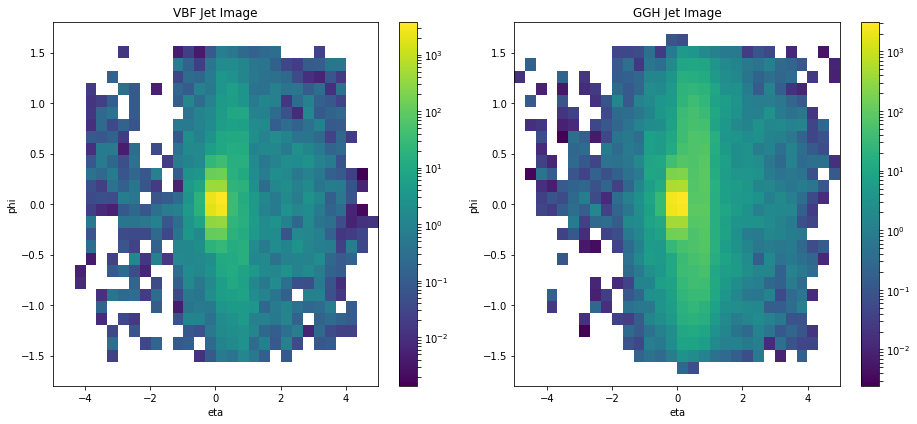

In [65]:
#chose amount of pixels
nx = 30
xmin = -5
xmax = 5
ny = 30
ymin = -1.8
ymax = 1.8
proc = [True,True,True,True]

#create and show jet images
vbf_jet_images, vbf_list_x, vbf_list_y, vbf_list_w, vbf_xbins, vbf_ybins = prepareImages(vbf_finputs, nx, xmin, xmax, ny, ymin, ymax, proc)

vbf_all_x = np.concatenate(vbf_list_x)
vbf_all_y = np.concatenate(vbf_list_y)
vbf_all_w = np.concatenate(vbf_list_w)
#vbf_all_w = 1.*vbf_all_w/len(vbf_jet_images) # to get average

ggh_jet_images, ggh_list_x, ggh_list_y, ggh_list_w, ggh_xbins, ggh_ybins = prepareImages(ggh_finputs, nx, xmin, xmax, ny, ymin, ymax, proc)

ggh_all_x = np.concatenate(ggh_list_x)
ggh_all_y = np.concatenate(ggh_list_y)
ggh_all_w = np.concatenate(ggh_list_w)
#ggh_all_w = 1.*ggh_all_w/len(ggh_jet_images) # to get average

fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(13)

fig1 = fig.add_subplot(121)
fig1 = pyp.hist2d(vbf_all_x, vbf_all_y, weights=vbf_all_w, bins=(vbf_xbins,vbf_ybins), norm=mpl.colors.LogNorm())
fig1 = pyp.colorbar()
fig1 = pyp.xlabel('eta')
fig1 = pyp.ylabel('phi')
fig1 = pyp.title('VBF Jet Image')

fig2 = fig.add_subplot(122)
fig2 = pyp.hist2d(ggh_all_x, ggh_all_y, weights=ggh_all_w, bins=(ggh_xbins,ggh_ybins), norm=mpl.colors.LogNorm())
fig2 = pyp.colorbar()
fig2 = pyp.xlabel('eta')
fig2 = pyp.ylabel('phi')
fig2 = pyp.title('GGH Jet Image')

pyp.tight_layout()
fig = pyp.show()

In [49]:
# Model
def build_conv_model():
    input_layer = Input(shape=(1, nx, ny))
    layer = Convolution2D(8, (4, 4), padding='same')(input_layer)
    layer = Activation('relu')(layer)
    layer = Convolution2D(8, (4, 4), padding='same')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(20)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

conv_model = build_conv_model()
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 30, 30)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 30, 30)         136       
_________________________________________________________________
activation_7 (Activation)    (None, 8, 30, 30)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 30, 30)         1032      
_________________________________________________________________
activation_8 (Activation)    (None, 8, 30, 30)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 15, 15)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1800)              0         
__________

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_4)`
  


In [50]:
#prepare inputs for model
X = np.concatenate([vbf_jet_images, ggh_jet_images])
Y_vbf = np.ones(vbf_jet_images.shape[0])
Y_ggh = np.zeros(ggh_jet_images.shape[0])
Y = np.concatenate([Y_vbf, Y_ggh])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

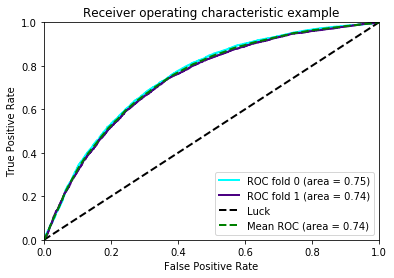

Train on 13104 samples, validate on 13106 samples
Epoch 1/10
13104/13104 [==============================] - 92s - loss: 0.6639 - acc: 0.6361 - val_loss: 0.6262 - val_acc: 0.6785
Epoch 2/10
13104/13104 [==============================] - 92s - loss: 0.6327 - acc: 0.6571 - val_loss: 0.6215 - val_acc: 0.6862
Epoch 3/10
13104/13104 [==============================] - 93s - loss: 0.6271 - acc: 0.6717 - val_loss: 0.6242 - val_acc: 0.6789
Epoch 4/10
13104/13104 [==============================] - 93s - loss: 0.6229 - acc: 0.6712 - val_loss: 0.6191 - val_acc: 0.6834
Epoch 5/10
13104/13104 [==============================] - 92s - loss: 0.6190 - acc: 0.6745 - val_loss: 0.6191 - val_acc: 0.6828
Epoch 6/10
13104/13104 [==============================] - 92s - loss: 0.6180 - acc: 0.6762 - val_loss: 0.6176 - val_acc: 0.6804
Epoch 7/10
13104/13104 [==============================] - 92s - loss: 0.6122 - acc: 0.6819 - val_loss: 0.6131 - val_acc: 0.6875
Epoch 8/10
13104/13104 [==============================

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_5)`
  
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_6)`
  


In [51]:
# Train and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    conv_model = build_conv_model()
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), epochs=10, batch_size=232, verbose=1, callbacks=[early_stopping])
    Y_score = conv_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyp.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
pyp.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyp.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver operating characteristic example')
pyp.legend(loc="lower right")
pyp.show()

In [52]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    if K.image_dim_ordering()=='tf':
        x = x.transpose((1, 2, 0))
        x = x.transpose((1, 0, 2))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

In [61]:
# dimensions of the generated pictures for each filter.
img_width = nx
img_height = ny

layer_dict = dict([(layer.name, layer) for layer in conv_model.layers])
input_img = conv_model.input

pics = {}
num_filters = {}
for key, layer in layer_dict.iteritems():
    #if 'convolution2d' in key:
    if 'conv2d' in key:
        num_filters[key] = 8
        
layer_name = num_filters.keys()[1]

print num_filters.keys()
print layer_name # here we pick which layer to visualize

['conv2d_11', 'conv2d_12']
conv2d_12


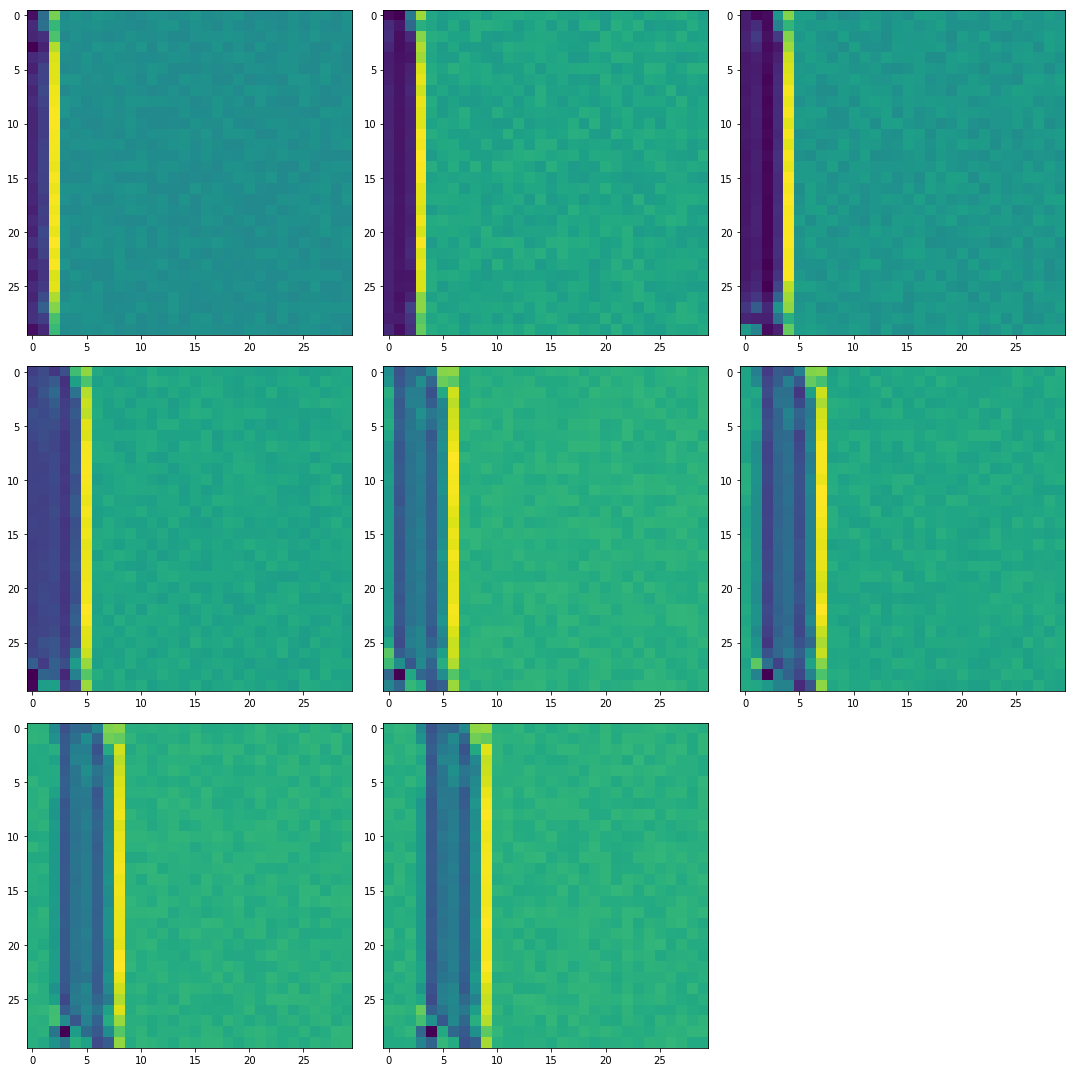

In [62]:
kept_filters = []
for filter_index in range(0,num_filters[layer_name]):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering()=='tf':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    
    if K.image_dim_ordering()=='tf':
        input_img_data = np.random.random((1, img_width, img_height, 1))
    else:
        input_img_data = np.random.random((1, 1, img_width, img_height))
        
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 100 steps
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    # decode the resulting input image
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    
fig = pyp.figure(figsize=(15,15))
i = 0
j = 0
for img, loss  in kept_filters:
    i+=1
    fig.add_subplot(3,3,i)
    pyp.imshow(img[0])
    #pyp.colorbar()
    
pyp.tight_layout()
fig = pyp.show()